## Required Packages

In [1]:
%matplotlib inline

In [2]:
%matplotlib notebook
from ipywidgets import *

from datetime import datetime, timedelta
import pandas as pd
import shapefile as shp

import cartopy.crs as ccrs
import math
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.patches as mpatches

## Opening Datasets
### Then assigning datasets to a combined list to run through easier

In [3]:
ds = xr.open_dataset('nos.leofs.fields.n006.20191014.t00z.nc', drop_variables=['siglay','siglev'], decode_times=False)
ds2 = xr.open_dataset('nos.leofs.fields.n006.20191015.t00z.nc', drop_variables = ['siglay', 'siglev'], decode_times=False)
ds3 = xr.open_dataset('nos.leofs.fields.n006.20191016.t00z.nc', drop_variables = ['siglay', 'siglev'], decode_times=False)
ds4 = xr.open_dataset('nos.leofs.fields.n006.20191017.t00z.nc', drop_variables = ['siglay', 'siglev'], decode_times=False)
ds5 = xr.open_dataset('nos.leofs.fields.n006.20191018.t00z.nc', drop_variables = ['siglay', 'siglev'], decode_times=False)

In [4]:
datasets = list([ds,ds2,ds3,ds4,ds5])

### Creating a dataset which is used to store the combined wind speed variable to coordinate the color guide to the wind speed of each node

In [5]:
for item in datasets:
    lats = item.latc.data
    lons = item.lonc.data
    uwnd = item['uwind_speed']
    vwnd = item['vwind_speed']
    time = item['time']
    uwnd_500 = gaussian_filter(uwnd.data[0], sigma=3.0) * units('m/s')
    vwnd_500 = gaussian_filter(vwnd.data[0], sigma=3.0) * units('m/s')
    
    V = np.array(vwnd_500)
    U = np.array(uwnd_500)
    
    out_data = pd.DataFrame()
    out_data['latc'] = item.latc
    out_data['lonc'] = item.lonc
    out_data['u_wind'] = uwnd_500
    out_data['v_wind'] = vwnd_500
    out_data['combined wind speed'] = out_data['u_wind'] + out_data['v_wind']

## Setting up the background shapefile of Lake Erie

In [6]:
shape_path = "hydro_p_LakeErie.shp"
sf = shp.Reader(shape_path)

In [7]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [8]:
df = read_shapefile(sf)

In [9]:
def plot_maps(sf, x_lim = None, y_lim = None, figsize = (20,15)):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.xlabel = 'Latitude'
        plt.ylabel = 'Longitude'
        plt.plot(x, y, 'k')
        
        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            plt.text(x0, y0, id, fontsize=10)
        id = id+1
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

### The Shapefile contained random dividing lines, the functions and lines of code below fix this issue

In [10]:
usa = df[df.COUNTRY == 'USA']
canada = df[df.COUNTRY== 'CAN']

In [11]:
usa_coords = usa.coords.iloc[0]
canada_coords = canada.coords.iloc[0]
coords = usa_coords + canada_coords

In [12]:
def plot_coords(coords):
    ### This function plots each coordinate pair
    ### to allow us to use the distance function below
    plt.figure(figsize=(15, 10))
    x = [shape[0] for shape in coords]
    y = [shape[1] for shape in coords]
    plt.plot(x, y, 'k')
    plt.show()

In [13]:
def calculate_distance(shape1, shape2):
    ### This function helps us calculate the distance
    ### between each pair of coorinates to help find
    ### the problematic ones causing random contour lines
    ys = (shape2[1]  - shape1[1]) ** 2
    xs = (shape2[0] - shape1[0]) ** 2
    dist = math.sqrt(xs + ys)
    return dist

#### Finding the outliying coordinate pairs who have significant differences between distance

In [14]:
distances = []
for i in range(1, len(coords)):
    distances.append(calculate_distance(coords[i - 1], coords[i]))
    
outliers = [x for x in distances if x > 0.5]
outliers

[0.5723031106613282, 3.3703614729573963, 3.3305645172028173]

#### Reformatting the shapefile to exclude the outlying points

In [15]:
modified_coords = coords[:468] + coords[818:]
canadian_half = coords[469:817]
american_half = coords[:431]

#### Creating the X and Y components of Lake Erie for both the American (am) and Canadian (c) halves of the lake

In [16]:
amx = [shape[0] for shape in american_half]
amy = [shape[1] for shape in american_half]
cx = [shape[0] for shape in canadian_half]
cy = [shape[1] for shape in canadian_half]

## Defining a color guide for the visualization based on the Beufort Scale for wind speeds

#### Combining the u and v wind data to use as a measure to set the color guide below

In [17]:
out_data['combined wind speed'] = out_data['u_wind'] + out_data['v_wind']

#### Manually setting the ranges for each color

In [18]:
color_guide = []
for speed in out_data['combined wind speed']:
    if speed >= 0 and speed < 1:
        color_guide.append('navy')
    elif speed >= 1 and speed < 4:
        color_guide.append('blue')
    elif speed >= 4 and speed < 8:
        color_guide.append('skyblue')
    elif speed >= 8 and speed < 13:
        color_guide.append('cyan')
    elif speed >= 13 and speed < 19:
        color_guide.append('teal')
    elif speed >= 19 and speed < 25:
        color_guide.append('lime')
    elif speed >= 25 and speed < 32:
        color_guide.append('green')
    elif speed >= 32 and speed < 39:
        color_guide.append('tan')
    elif speed >= 39 and speed < 47:
        color_guide.append('yellow')
    elif speed >= 47 and speed < 64:
        color_guide.append('orange')
    elif speed >= 64 and speed < 75:
        color_guide.append('red')
    elif speed >= 75:
        color_guide.append('pink')

## Setting up the visualization
#### Need to run the block below for the final visualization to work

<IPython.core.display.Javascript object>


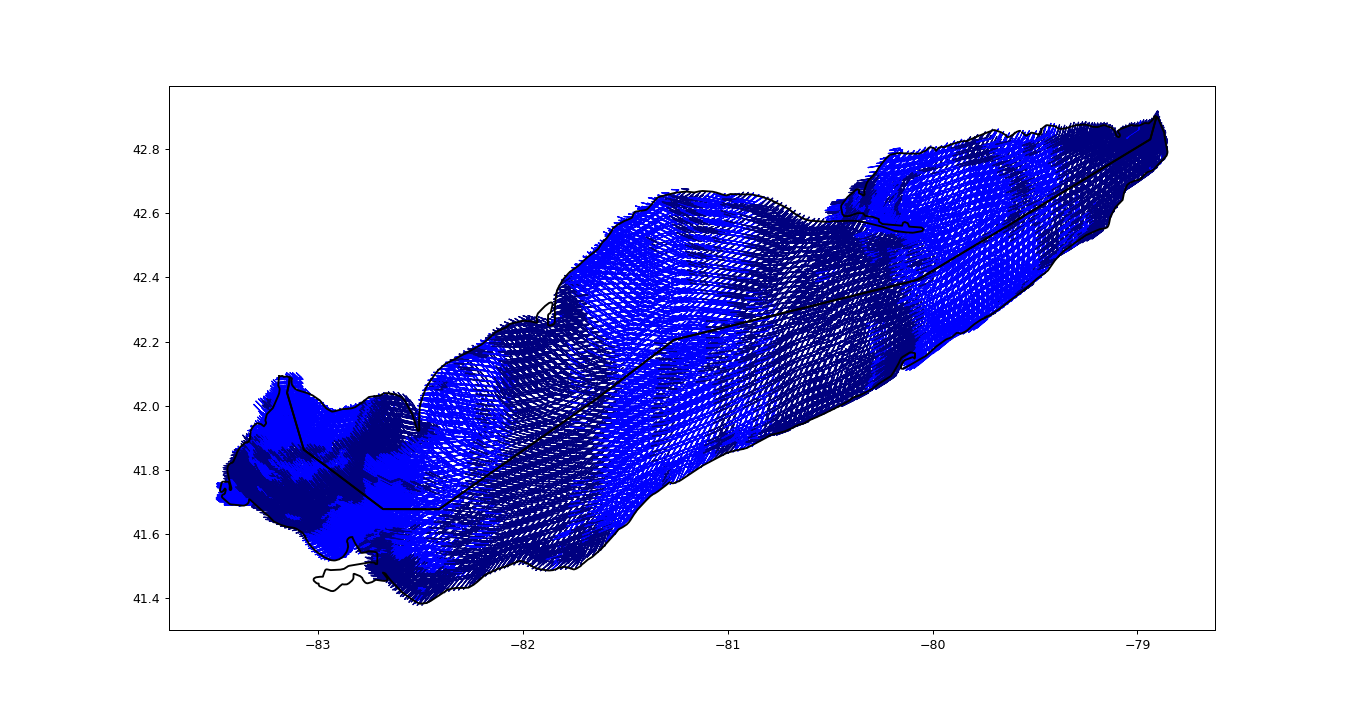

In [20]:
for item in datasets:
    lats = item.latc.data
    lons = item.lonc.data
    lons = np.where(lons > 180., lons-360., lons)
    uwnd = item['uwind_speed']
    vwnd = item['vwind_speed']
    time = item['time']

    uwnd_500 = gaussian_filter(uwnd.data[0], sigma=3.0) * units('m/s')
    vwnd_500 = gaussian_filter(vwnd.data[0], sigma=3.0) * units('m/s')
    V = np.array(vwnd_500)
    U = np.array(uwnd_500)
    
    plt.figure(figsize=(15, 8))
    ax = plt.subplot(111)

    plt.plot(amx, amy, 'k')
    plt.plot(cx, cy, 'k')

    barbs = plt.barbs(lons, lats, U, V, length = 4,pivot='middle',color=color_guide, flagcolor='black', sizes={'width':2, 'height':1, 'spacing':1})

#     plt.legend(color_guide, loc='lower right', title='Wind Speeds', fontsize='xx-large')

    plt.show()
    plt.savefig('full wind lake erie.png')
    break

# Plotting the Visualization

<IPython.core.display.Javascript object>


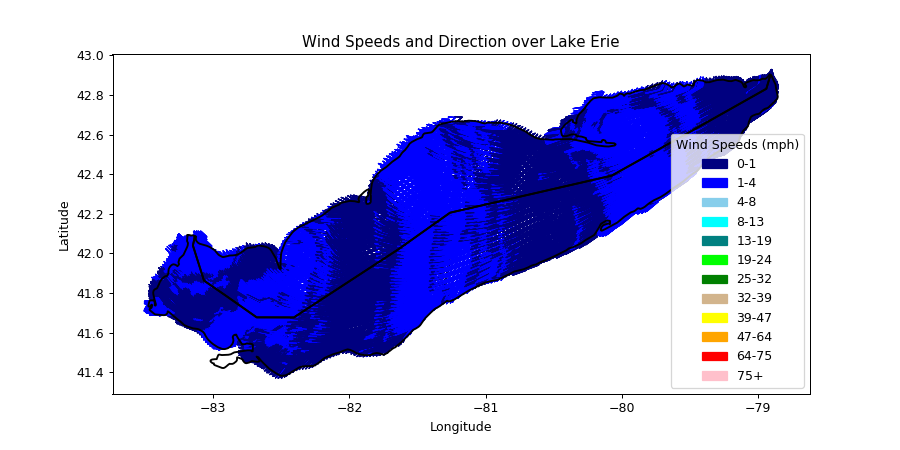

interactive(children=(FloatSlider(value=0.0, description='Date', max=4.0, step=1.0), Output()), _dom_classes=(…

In [21]:
# Creating the background of the plot

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)


plt.plot(amx, amy, 'k')
plt.plot(cx, cy, 'k')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Wind Speeds and Direction over Lake Erie')

# Set up for the legend, recreating the color_guide beufort scale from above

navy = mpatches.Patch(color='navy', label='0-1')
blue = mpatches.Patch(color='blue', label='1-4')
skyblue = mpatches.Patch(color='skyblue', label='4-8')
cyan = mpatches.Patch(color='cyan', label='8-13')
teal = mpatches.Patch(color='teal', label='13-19')
lime = mpatches.Patch(color='lime', label='19-24')
green = mpatches.Patch(color='green', label='25-32')
tan = mpatches.Patch(color='tan', label='32-39')
yellow = mpatches.Patch(color='yellow', label='39-47')
orange = mpatches.Patch(color='orange', label='47-64')
red = mpatches.Patch(color='red', label='64-75')
pink = mpatches.Patch(color='pink', label='75+')

# Plotting the wind barbs, adding the time label next to the slider, and applying the legend

barbs = plt.barbs(lons, lats, U, V, length = 4,pivot='middle',color=color_guide, flagcolor='black', sizes={'width':2, 'height':1, 'spacing':1})
refdate = datetime.strptime("2019-10-14", "%Y-%m-%d")
plt.legend(handles=[navy, blue, skyblue, cyan, 
                    teal, lime, green, tan, 
                    yellow, orange, red, pink],loc='lower right', title='Wind Speeds (mph)', fontsize='medium')

# a function to define the whole plot with the slider and to ensure the plot updates as the slider moves

def update(Date):

    Date = int(Date)
    lats = datasets[Date].latc.data
    lons = datasets[Date].lonc.data
    lons = np.where(lons > 180., lons-360., lons)
    uwnd = datasets[Date]['uwind_speed']
    vwnd = datasets[Date]['vwind_speed']
    time = datasets[Date]['time']
    
    current_date = refdate + timedelta(days = Date) #can be tweaked to change to 6 hour format as datasets are in
    print(current_date.strftime("%m %d %Y"))

    uwnd_500 = gaussian_filter(uwnd.data[0], sigma=3.0) * units('m/s')    # these two lines use a gaussian filter to reformat the data from an array to a list, in the proper units
    vwnd_500 = gaussian_filter(vwnd.data[0], sigma=3.0) * units('m/s')
    V = np.array(vwnd_500)
    U = np.array(uwnd_500)
    barbs = plt.barbs(lons, lats, U, V, length = 4,pivot='middle',color=color_guide, flagcolor='black', sizes={'width':2, 'height':1, 'spacing':1})
    fig.canvas.draw_idle()
    plt.show()


interact(update, Date = widgets.FloatSlider(value=0,
                                               min=0,
                                               max=4,
                                               step=1));
plt.show()
plt.savefig('Wind over Lake Erie.jpg')